# Interaction with the World Homework (#3)
Python Computing for Data Science (c) J Bloom, UC Berkeley, 2016

# 1) Monty: The Python Siri

Let's make a Siri-like program with the following properties:
   - record your voice command
   - use a webservice to parse that sound file into text
   - based on what the text, take three different types of actions:
       - send an email to yourself
       - do some math
       - tell a joke

So for example, if you say "Monty: email me with subject hello and body goodbye", it will email you with the appropriate subject and body. If you say "Monty: tell me a joke" then it will go to the web and find a joke and print it for you. If you say, "Monty: calculate two times three" it should response with printing the number 6.

Hint: you can use speed-to-text apps like Houndify to return the text (but not do the actions). You'll need to sign up for a free API and then follow documentation instructions for using the service within Python. 

# 2) Write a program that identifies musical notes from sound (AIFF) files. 

  - Run it on the supplied sound files (12) and report your program’s results. 
  - Use the labeled sounds (4) to make sure it works correctly. The provided sound files contain 1-3 simultaneous notes from different organs.
  - Save copies of any example plots to illustrate how your program works.
  
  https://piazza.com/berkeley/fall2016/ay250/resources -> hw3_sound_files.zip

Hints: You’ll want to decompose the sound into a frequency power spectrum. Use a Fast Fourier Transform. Be care about “unpacking” the string hexcode into python data structures. The sound files use 32 bit data. Play around with what happens when you convert the string data to other integer sizes, or signed vs unsigned integers. Also, beware of harmonics.

In [1]:
import sys
sys.executable
sys.path

['',
 '/usr/local/Cellar/python3/3.5.2_1/Frameworks/Python.framework/Versions/3.5/lib/python35.zip',
 '/usr/local/Cellar/python3/3.5.2_1/Frameworks/Python.framework/Versions/3.5/lib/python3.5',
 '/usr/local/Cellar/python3/3.5.2_1/Frameworks/Python.framework/Versions/3.5/lib/python3.5/plat-darwin',
 '/usr/local/Cellar/python3/3.5.2_1/Frameworks/Python.framework/Versions/3.5/lib/python3.5/lib-dynload',
 '/Users/echoes/Library/Python/3.5/lib/python/site-packages',
 '/usr/local/lib/python3.5/site-packages',
 '/Users/echoes/Library/Python/3.5/lib/python/site-packages/IPython/extensions',
 '/Users/echoes/.ipython']

In [4]:
# Import
from pyaudio import PyAudio
from pyaudio import paFloat32
from pyaudio import paContinue
from time import sleep
from numpy import array, random, arange, float32, float64, zeros
import matplotlib.pyplot as plt

/Users/echoes/Library/Python/3.5/lib/python/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/Users/echoes/Library/Python/3.5/lib/python/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [ ]:
# References: 

# http://samcarcagno.altervista.org/blog/basic-sound-processing-python/

# https://gist.github.com/endolith/255291

# http://www.cs.tut.fi/sgn/arg/intro/basics.html

# https://github.com/endolith/waveform-analyzer/blob/master/frequency_estimator.py

In [5]:
################################### Constants ##################################

fs            = 44100   # Hz
threshold     = 0.8     # absolute gain
delay         = 40      # samples
signalLength  = 1       # second
relCoeff      = 0.9999  # release time factor
attCoeff      = 0.9     # attack time factor
dtype         = 'float32' # default data type
blockLength   = 1024    # samples

In [6]:

#################### Generate quiet-loud-quiet noise signal ####################

signal = array(random.rand(fs * signalLength) * 2 - 1, dtype = dtype)
signal[:signalLength * fs / 3] *= 0.1
signal[signalLength * fs * 2 / 3:] *= 0.1

/Users/echoes/Library/Python/3.5/lib/python/site-packages/ipykernel/__main__.py:5: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/echoes/Library/Python/3.5/lib/python/site-packages/ipykernel/__main__.py:6: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [7]:
class AudioLimiter(object):
    
    def __init__(self, attCoeff, relCoeff, delay, dtype = 'float32'):
        self.delayIdx = 0
        self.env = 0
        self.gain = 1
        self.delay = delay
        self.delayLine = zeros(delay, dtype = dtype)
        self.attCoeff = attCoeff
        self.relCoeff = relCoeff
        
    def getLimit(self, signal, threshold):
        for i in arange(len(signal)):
            self.delayLine[self.delayIdx] = signal[i]
            self.delayIdx = (self.delayIdx + 1) % self.delay
            
            # Calc env of signal
            self.env *= self.relCoeff
            self.env = max(abs(signal[i]), self.env)
            
            # Gain moves towards limiter gain
            if(self.env > threshold):
                targetGain = (1 + threshold - self.env)
            else:
                targetGain = 1.0
            self.gain = (self.gain * self.attCoeff + targetGain * (1 - self.attCoeff))
            
            # Limit the delayed signal
            signal[i] = self.delayLine[self.delayIdx] * self.gain

In [8]:
def callback(dIn, frameCount, timeInfo, flag):
    if(flag):
        print("Playback error: %i" % flag)
    global counter
    playedFrames = counter
    counter += frameCount
    audioLimit.getLimit(signal[playedFrames:counter], threshold)
    return signal[playedFrames:counter], paContinue

#callback.counter = 0
counter = 0

In [9]:
originalSignal = array(signal, copy = True, dtype = dtype)

audioLimit = AudioLimiter(attCoeff, relCoeff, delay, dtype) 

In [10]:
pa = PyAudio()

In [11]:

# Real-time audio processing
audioStream = pa.open(format = paFloat32,
                     channels = 1,
                     rate = 44100,
                     output = True,
                     frames_per_buffer = 1024,
                     stream_callback = callback)

while audioStream.is_active():
    sleep(0.1)
    
audioStream.close()
pa.terminate()

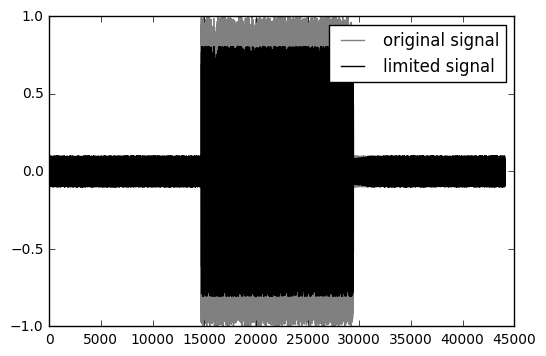

In [12]:
plt.figure()
plt.plot(originalSignal, color = 'grey', label = 'original signal')
plt.plot(signal, color = 'black', label = 'limited signal')
plt.legend()
plt.show(block = True)

In [ ]:
### Alternative way to save plots 

from numpy import *
from matplotlib.pyplot import *

random.seed(0)
noise = random.randn(5000)
noise /= max(noise)
envelope = zeros(5000)
gain = ones(5000)

threshold = 0.85

for i in arange(len(noise)):
    envelope[i] = max(abs(envelope[i-1]) * 0.9998, abs(noise[i]))
    if envelope[i] > threshold:
        target_gain = 1.0 + threshold - envelope[i]
    else:
        target_gain = 1.0
    gain[i] = gain[i-1]*0.8 + target_gain*(1-0.8)

figure(figsize=(5,2.5))
plot(abs(noise), color='lightgrey', label='|noise|')
plot(envelope, color='black', linewidth=2, label='envelope')
xlabel('time/samples')
xticks(())
ylabel('gain/linear')
yticks(())
legend(loc='lower right')
tight_layout()
savefig('envelope.png')

plot((0, len(noise)),(threshold,threshold), color='grey', linewidth=2)
plot(gain-(1-threshold), color='red', linewidth=2, label='gain')
legend(loc='lower right')
savefig('gain.png')

xlim(3000,3200)
ylim(0.6,1.1)
legend().set_visible(False)
savefig('detail.png')

In [26]:
import scipy.io.wavfile
import aifc
import numpy as np

#rate, dat = scipy.io.wavfile.read("hw3_data/sound_files/1.aif", mmap = False)

audio = aifc.open("hw3_data/sound_files/F3_popOrgan.aif")
frames = audio.getnframes()
channels = audio.getnchannels()
frameRate = audio.getframerate()

In [27]:
datBytes = audio.readframes(frames)

In [28]:
frames

705600

In [29]:
#len(dat)

In [30]:
dat = np.fromstring(datBytes, dtype = np.int32)

In [31]:
dat.shape

(705600,)

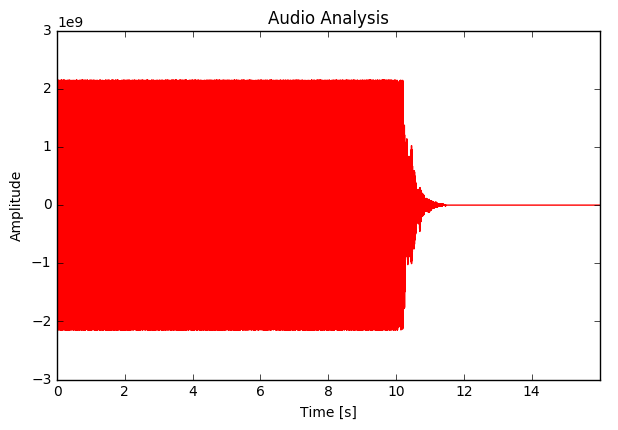

In [32]:
# Amplitude to time 

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy import *

#integer_data = fromstring(data, dtype=np.int32)
time = arange(size(dat)) / float(frameRate)
plot_title = ("Audio Analysis")

fig = plt.figure(figsize=(7, 4.5))
ax1 = fig.add_subplot(1,1,1)
ax1.plot(time, dat, color="red", linestyle="-")
ax1.set_xlabel("Time [s]")
ax1.set_ylabel("Amplitude")
ax1.set_xlim(min(time), max(time))
ax1.set_title(plot_title)

In [33]:
# Make power spectrogram 

from scipy import signal

#f, Pxx_spec = signal.periodogram(dat, frameRate, 'flattop', scaling = 'spectrum')
f, Pxx_dens = signal.periodogram(dat, frameRate)

In [34]:
f.shape

(352801,)

In [35]:
Pxx_dens.shape

(352801,)

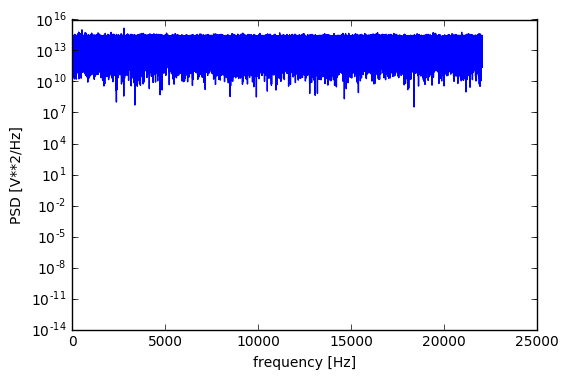

In [36]:
plt.semilogy(f, Pxx_dens)
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')
plt.show()

In [37]:
np.mean(Pxx_dens[256:])

44279259818415.5

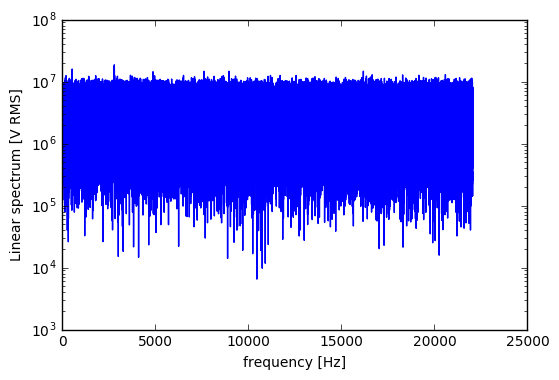

In [38]:
f, Pxx_spec = signal.periodogram(dat, frameRate, 'flattop', scaling='spectrum')
plt.figure()
plt.semilogy(f, np.sqrt(Pxx_spec))
plt.xlabel('frequency [Hz]')
plt.ylabel('Linear spectrum [V RMS]')
plt.show()

In [39]:
# Peak height in power spectrum is an estimate Root Mean Square amplitude 
np.sqrt(Pxx_spec.max())

18577811.240173616

In [40]:
frameRate

44100

In [42]:
#audioFFT.shape

In [43]:
# Approach with numpy 

#p = 20 * np.log10(np.abs(np.fft.rfft(dat)))


# Phase spectrum 
audioData = dat
audioFFT = np.fft.rfft(audioData)
audioAmp = np.abs(audioFFT)
audioPower = np.abs(audioFFT)**2
audioPhase = np.angle(audioFFT)

# fftfreq(n, d), d = inverse of sampling rate 
audioFreqs = np.fft.fftfreq(audioFFT.size, 1 / frameRate)
audioIdx = np.argsort(audioFreqs)

# Take log10 of Amp to get in dB (decibels)

f = np.linspace(0, frameRate / 2, len(audioFFT))

In [44]:
audioIdx.size


352801

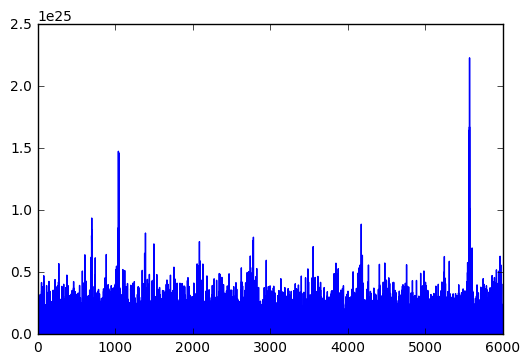

In [104]:
audioFreqsIdx = audioFreqs[audioIdx]
audioPowerIdx = audioPower[audioIdx]

plt.xlim(0, 6000)
#plt.plot(audioFreqs[audioIdx], audioPower[audioIdx])
plt.plot(audioFreqsIdx, audioPowerIdx)

In [105]:
audioPowerMax = audioPowerIdx.max()
audioPowerMaxIdx = audioPowerIdx.argmax()
powerMaxIdx = audioPowerIdx.argsort()
#audioFreqs.index(max(audioPower[audioIdx]))
#idx(audioPower[audioIdx])

In [108]:
np.log10(np.abs(audioPowerMax)**2)

50.696831749046268

In [107]:
audioFreqsIdx.shape

(352801,)

In [49]:
#audioPowerIdx[powerMaxIdx[-1]]

In [54]:
#np.where(audioPowerIdx == audioPowerIdx.max())

audioPowerIdx[powerMaxIdx[-30:], ]

array([  1.01921214e+25,   1.02162355e+25,   1.02887408e+25,
         1.04295309e+25,   1.04939237e+25,   1.05144310e+25,
         1.06327120e+25,   1.08074304e+25,   1.09795336e+25,
         1.14546602e+25,   1.16406302e+25,   1.16507527e+25,
         1.16912875e+25,   1.17088827e+25,   1.19797608e+25,
         1.24705266e+25,   1.26474942e+25,   1.28701606e+25,
         1.29104691e+25,   1.33757812e+25,   1.34117312e+25,
         1.38946275e+25,   1.39861988e+25,   1.40028492e+25,
         1.46400599e+25,   1.47702554e+25,   1.48704540e+25,
         1.64559727e+25,   1.67358523e+25,   2.23057009e+25])

In [100]:
audioFreqs100 = audioFreqsIdx[powerMaxIdx[-100:], ]
audioFreqs100.shape

(100,)

In [93]:
audioFreqsNonneg = audioFreqs100

In [96]:
 nonnegFreqs100 = audioFreqs100[audioFreqs100 > 0]

/Users/echoes/Library/Python/3.5/lib/python/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in greater
  if __name__ == '__main__':


In [102]:
nonnegFreqs100.min()

697.24802367340226

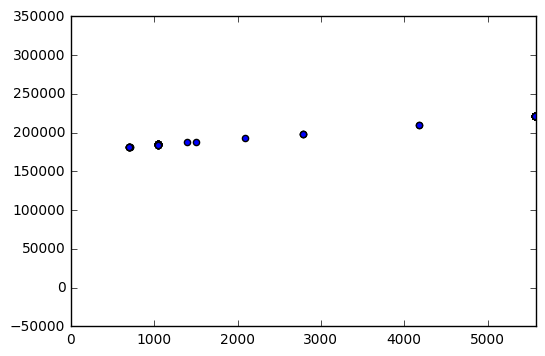

In [103]:
plt.xlim(0, 5580)
#plt.ylim(220600, 221300)
plt.scatter(audioFreqsIdx[powerMaxIdx[-100:], ], powerMaxIdx[-100:])

In [ ]:
# Make spectrogram 

#x = s1 + s2 + nse  # the signal
#NFFT = 1024       # tzhe length of the windowing segments
#Fs = int(1.0/dt)  # the sampling frequency

# Pxx is the segments x freqs array of instantaneous power, freqs is
# the frequency vector, bins are the centers of the time bins in which
# the power is computed, and im is the matplotlib.image.AxesImage
# instance

#ax1 = plt.subplot(211)
#plt.plot(t, x)
#plt.subplot(212, sharex=ax1)
#Pxx, freqs, bins, im = plt.specgram(x, NFFT=NFFT, Fs=Fs, noverlap=900,
#                                cmap=plt.cm.gist_heat)
#plt.show()


%matplotlib inline
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="white", context="poster")

Pxx, freqs, bins, im = plt.specgram(dat, NFFT = 2048 * 2, Fs = rate, noverlap = 512,
                                cmap = plt.cm.viridis)
plt.ylim(1,18000)
plt.xlabel("Time [sec]")
plt.ylabel("Frequency [Hz]")